![Lights!Camera!Action](Movie_photo.jpg)

---
# BOX Office Movies Analysis
---

## Overview
This project analyzes data from multiple sources from the film industry in order to determine which films yield the highest ROI (Return on Investment/ profitability) based on genres and the release month in order to advise a company planning on starting a film studio. Descriptive analysis enables us to dtermine which films perform the best based on ROI and average rating of the films to enable the company to decide what films to create. 


## Business Problem
Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

---
## Data Understanding
---

The data that is being used has been sourced from different platforms and contains information such as:
- Movie titles
- Movie Genres
- Production costs
- Gross income made
- Ratings

With this data we can make conclusions regarding what types of films to create based on consumer preference(rating), production costs and the income made from production in order to answer the business problem. 

### Loading the data into dataframes

In [28]:
#importing necesarry libraries
import pandas as pd
import numpy as np 
import sqlite3

#### Movie Budgets Data
This dataframe contains data to do with numbers i.e the money generated from the film, the movie name, release date and the production budget. This will for the foundation on which we will conduct our analysis. 

In [29]:
# Specify the file path
file_path = "zippedData/tn.movie_budgets.csv.gz"

# Load the data into a DataFrame
movie_budgets = pd.read_csv(file_path, compression='gzip')

movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [30]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


#### Movies ERD

![movies erd](movie_data_erd.jpeg)

#### Im.db File
This file is a database that contains numerous tables each with valeable information. For this analysis we will focus on the directors, movie name, ratings and genres.  

In [110]:
#load the movie_basics data into a dataframe
#unzip the file
import zipfile

with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
  # Extract all files (assuming the database file is the only one)
  zip_ref.extractall()

# Connect to the SQLite database
with sqlite3.connect('im.db') as conn:
    #write a query to select the necessary columns
    q ="""SELECT
    mb.primary_title,
    mb.genres,
    p.primary_name, mr.averagerating
    FROM movie_basics AS mb
    JOIN movie_ratings as mr
        ON mr.movie_id = mb.movie_id
    JOIN directors AS d
        ON mb.movie_id = d.movie_id
    JOIN persons AS p
        ON d.person_id = p.person_id
    GROUP BY mb.primary_title
    HAVING primary_profession LIKE '%director%';"""
    # Load the tables into a DataFrame
    movie_basics = pd.read_sql_query(q, conn)

#close connection
conn.close()

# Display the first few rows of the DataFrame
movie_basics.head()

,primary_title,genres,primary_name,averagerating
0,!Women Art Revolution,Documentary,Lynn Hershman-Leeson,6.90
1,#1 Serial Killer,Horror,Stanley Yung,5.60
2,#5,"Biography,Comedy,Fantasy",Ricky Bardy,6.80
3,#66,Action,Asun Mawardi,5.30
4,#ALLMYMOVIES,Documentary,Shia LaBeouf,8.30


In [111]:
import atexit
import os

def delete_file_on_exit(file_path):
    os.remove(file_path)

atexit.register(delete_file_on_exit, 'im.db')


<function __main__.delete_file_on_exit(file_path)>

---
## Data Preparation
---

### Data Cleaning

#### Tmbd_movies cleaning
This table contans the numbers needed to perform calculations. I will rename the **movie** column to **movie_title** for ease of use. I will also convert the  useful money columns i.e **production_budget** and **worldwide_gross** into float values and make them easier to use when performing computations.As for the **release_date** column I will split it to maintain the month value and discard the original column. Lastly, I will convert the **worldwide_gross** column into a format that is eay to read. 


In [33]:
#rename the movie column
movie_budgets = movie_budgets.rename(columns={'movie':'movie_title'})

#convert the release_date column to release_month
movie_budgets['release_month'] = movie_budgets['release_date'].str[:3].str.strip()

#delete unnecessary columns
movie_budgets = movie_budgets.drop(['id', 'release_date', 'domestic_gross'], axis=1)

In [34]:
#convert the production_budget and worldwide_gross columns to float 
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)

In [35]:
#display the world_gross column as an easier to read number
pd.set_option('display.float_format', '{:.2f}'.format)

In [36]:
#remove all columns where the worldwide_gross is 0
movie_budgets = movie_budgets[movie_budgets['worldwide_gross'] != 0]

In [37]:
movie_budgets.duplicated().sum()

0

#### Movie_basics Cleaning
Drop all rows with null values in the **genre** column. Rename the remaining two columns from **primary_title** to **movie_title** and **primary_name** to **director**

In [38]:
#drop all rows with NaN values
movie_basics = movie_basics.dropna()

In [39]:
#rename the columns 
movie_basics = movie_basics.rename(columns={'primary_title':'movie_title', 'primary_name':'director_name'})

## Merging Dataframes
Merge the two dataframes into one in ordeer to perform the analysis

In [53]:
#merge the movie_budgets and movie_basics dataframes
movies_data = pd.merge(movie_budgets,
                      movie_basics,
                      on=['movie_title'],
                      how='inner')

In [54]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796 entries, 0 to 1795
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_title        1796 non-null   object 
 1   production_budget  1796 non-null   float64
 2   worldwide_gross    1796 non-null   float64
 3   release_month      1796 non-null   object 
 4   genres             1796 non-null   object 
 5   director_name      1796 non-null   object 
 6   averagerating      1796 non-null   float64
dtypes: float64(3), object(4)
memory usage: 98.3+ KB


## Feature Engineering
Generate a new feature called ROI- Return on investments that measures the profitability of the movie.
This will show how each film profited based on the **production_budget** and **worlwide_gross**. 
I will also reorder the columns.

In [55]:
#calculate the ROI column
movies_data['ROI'] = movies_data['worldwide_gross'] - movies_data['production_budget']

In [56]:
#reorder the columns for easier reading
movies_data = movies_data[['movie_title', 'release_month', 'averagerating',
                            'worldwide_gross', 'ROI', 'genres', 'director_name']]

In [57]:
movies_data.head()

,movie_title,release_month,averagerating,worldwide_gross,ROI,genres,director_name
0,Avatar,Dec,6.10,2776345279.00,2351345279.00,Horror,Atsushi Wada
1,Pirates of the Caribbean: On Stranger Tides,May,6.60,1045663875.00,635063875.00,"Action,Adventure,Fantasy",Rob Marshall
2,Dark Phoenix,Jun,6.00,149762350.00,-200237650.00,"Action,Adventure,Sci-Fi",Simon Kinberg
3,Avengers: Age of Ultron,May,7.30,1403013963.00,1072413963.00,"Action,Adventure,Sci-Fi",Joss Whedon
4,Avengers: Infinity War,Apr,8.50,2048134200.00,1748134200.00,"Action,Adventure,Sci-Fi",Anthony Russo


In [45]:
#save the cleaned dataframe into csv files
movies_data.to_csv('cleaned_data/movies_data.csv', index=False)

---
## Analysis
---

### Box Office Perfomance

In this case we want to find out which movie genres are doing the best in Box Offices.
We will first group the data into **ROI** and **Genres** and create a new dataframe where we will further find the aggregates of the **ROI** interms of *count*, *mean* and *median*. I will thereafter use these measures of frequency and central tendancy to find the highest profiting genres(the top 10 to be exact). 


From the data, the highest profiting genres seem to be **Sci-Fi** and **Adventure** as the most profitable genres appearing in different combinations. 
The most profitable genre combinations in order are:
1. Action, Adventure, Sci-Fi
2. Adventure,Drama,Sci-Fi
3. Comedy,Mystery

I ignored the first value suggested by the data in the means beacuse I consider it an outlier and could skew the expected results and I chose 
 **Drama**, **Comedy** and  **Action** also seem to be highly profitable in different combinations. The **Documentary** genre was ignored because it only appeared in freqency rather than mean and median ROI. 


In [46]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [47]:
# Group the data by genre and calculate the mean ROI
genre_roi = movies_data[['genres', 'ROI']].groupby('genres').agg(['count', 'mean', 'median'])

In [48]:
#grouping by mean and ROI
genre_roi.sort_values(by=('ROI','count'),ascending=False).head(11)

ROI                          
                           count         mean       median
genres                                                    
Drama                        137  27658774.90   4391992.00
Comedy                        61  37823365.87  15286416.00
Drama,Romance                 55  35302275.89  10531500.00
Comedy,Drama,Romance          54  26111148.24   5262364.00
Adventure,Animation,Comedy    53 262811628.42 151091610.00
Documentary                   52  30609277.44    886290.50
Comedy,Drama                  51  32346846.27  13112154.00
Action,Adventure,Sci-Fi       51 483139106.27 369076069.00
Action,Crime,Drama            40  32431874.32  18688624.50
Comedy,Romance                38  58421388.97  30152398.00
Action,Adventure,Fantasy      35 233407819.20 143388614.00

In [49]:
#groupig by count and ROI
genre_roi.sort_values(by=('ROI','mean'),ascending=False).head(11)

ROI                            
                           count          mean        median
genres                                                      
Adventure,Drama,Sport          1 1122469910.00 1122469910.00
Adventure,Drama,Sci-Fi         2  524325409.00  524325409.00
Comedy,Mystery                 1  506464305.00  506464305.00
Action,Adventure,Sci-Fi       51  483139106.27  369076069.00
Adventure,Fantasy              3  469544026.33  695577621.00
Drama,Family,Fantasy           2  350121384.00  350121384.00
Adventure,Drama,Fantasy        4  334192689.25  338601398.50
Crime,Fantasy,Thriller         1  333620129.00  333620129.00
Action,Adventure,Animation    17  322257606.47  377599142.00
Crime,Drama,Family             1  321116343.00  321116343.00
Animation                      4  314169157.75  225739564.00

In [50]:
#grouping by median and ROI
genre_roi.sort_values(by=('ROI','median'),ascending=False).head(11)

ROI                            
                           count          mean        median
genres                                                      
Adventure,Drama,Sport          1 1122469910.00 1122469910.00
Adventure,Fantasy              3  469544026.33  695577621.00
Adventure,Drama,Sci-Fi         2  524325409.00  524325409.00
Comedy,Mystery                 1  506464305.00  506464305.00
Action,Adventure,Animation    17  322257606.47  377599142.00
Action,Adventure,Sci-Fi       51  483139106.27  369076069.00
Drama,Family,Fantasy           2  350121384.00  350121384.00
Animation,Comedy,Family        6  291988257.83  341503055.00
Adventure,Drama,Fantasy        4  334192689.25  338601398.50
Crime,Fantasy,Thriller         1  333620129.00  333620129.00
Crime,Drama,Family             1  321116343.00  321116343.00

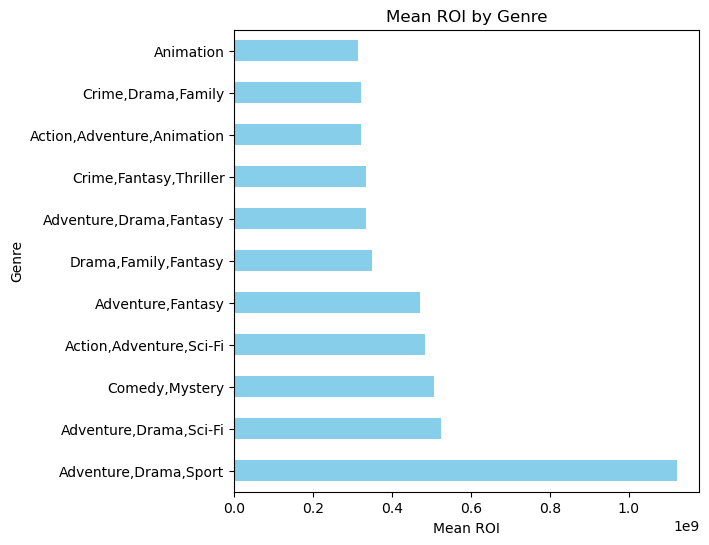

In [112]:
#plot a graph of the mean ROI by genre
fig, ax = plt.subplots(figsize=(6, 6))
mean_genre_roi = genre_roi.sort_values(by=('ROI','mean'),ascending=False).head(11)

ax = mean_genre_roi['ROI']['mean'].plot(kind='barh', figsize=(6, 6), color='skyblue')

ax.set_title('Mean ROI by Genre')
ax.set_xlabel('Mean ROI')
ax.set_ylabel('Genre')
plt.show();

### Release month against ROI
In this analysis I invetigate which would be the most profitable months to release a movie.
Most movies are released within the lasy three months of the year i.e **October**, **November** and **December**. However the months with the **highest average ROI** seem to be in the middle of the year between **May**, **June** and **July** with **November** following closely behind. 

The median average ROI of films relased by months emphasizes that although there are many films that do not provide a high ROI (some under $10 million) films typically released in **July** or **November** are bound to do well. 

In [60]:
#group the data into ROI and release month
release_roi =  movies_data[['release_month', 'ROI']].groupby('release_month').agg(['count', 'mean', 'median'])
release_roi

ROI                         
              count         mean      median
release_month                               
Apr             156  72622896.28  8408893.00
Aug             156  49791543.01 15825988.00
Dec             178 104804856.63 18651357.00
Feb             130  74495888.26 23704467.50
Jan             113  40911245.90 18330757.00
Jul             147 125142364.31 43018913.00
Jun             145 138844351.19 28527161.00
Mar             154  83288733.78 16055533.00
May             124 137378374.67 29044993.50
Nov             158 118476326.82 31108007.00
Oct             181  46523841.77  5500000.00
Sep             154  37332124.16 10266746.50

In [78]:
release_roi.sort_values(by=('ROI','mean'),ascending=False)

ROI                         
              count         mean      median
release_month                               
Jun             145 138844351.19 28527161.00
May             124 137378374.67 29044993.50
Jul             147 125142364.31 43018913.00
Nov             158 118476326.82 31108007.00
Dec             178 104804856.63 18651357.00
Mar             154  83288733.78 16055533.00
Feb             130  74495888.26 23704467.50
Apr             156  72622896.28  8408893.00
Aug             156  49791543.01 15825988.00
Oct             181  46523841.77  5500000.00
Jan             113  40911245.90 18330757.00
Sep             154  37332124.16 10266746.50

In [81]:
release_roi.sort_values(by=('ROI','median'),ascending=False)

ROI                         
              count         mean      median
release_month                               
Jul             147 125142364.31 43018913.00
Nov             158 118476326.82 31108007.00
May             124 137378374.67 29044993.50
Jun             145 138844351.19 28527161.00
Feb             130  74495888.26 23704467.50
Dec             178 104804856.63 18651357.00
Jan             113  40911245.90 18330757.00
Mar             154  83288733.78 16055533.00
Aug             156  49791543.01 15825988.00
Sep             154  37332124.16 10266746.50
Apr             156  72622896.28  8408893.00
Oct             181  46523841.77  5500000.00

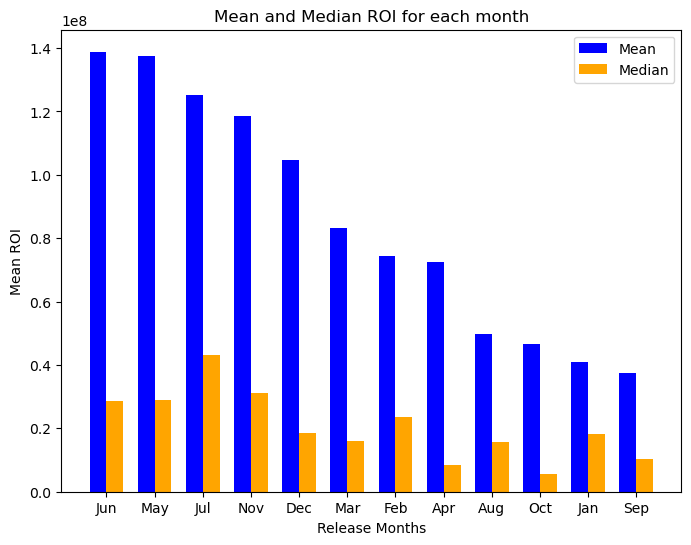

In [80]:
#set the bar width 
bar_width = 0.35

#data
mean_release_roi = release_roi.sort_values(by=('ROI','mean'),ascending=False)
# Create the plot
plt.figure(figsize=(8, 6))
index = np.arange(len(mean_release_roi))

# Plot the mean bars
plt.bar(index, mean_release_roi['ROI']['mean'], bar_width, label='Mean', color='blue')

# Plot the median bars
plt.bar(index + bar_width,mean_release_roi['ROI']['median'], bar_width, label='Median', color='orange')

# Set the title
plt.title('Mean and Median ROI for each month')
# Set the x-axis labels
plt.xlabel('Release Months')
plt.xticks(index + bar_width / 2, mean_release_roi.index)

# Set the y-axis label
plt.ylabel('Mean ROI')

# Add a legend
plt.legend()

# Show the plot
plt.show()


#### Directors Who are Most Likely to create a film with a High ROI and Positive Rating
Right of the bat we can seen that the top 5 most common director names in the film industry are: *David Gordon Green*, *Steven Soderbergh*, *Steven Spielberg*, *Ridley Scott* and *Jon M. Chu*. What's that thing they always say? **Practice makes perfect right?** 
These money makers in the industry are likely to get the audience exited as they know what direction the film will take and thay have directed films that are above the average rating of 6.27, well except *Jon M. Chu*. He is not to be discared so lightly based of public opinion because he happens to direct films **that generate an impresive High ROI**.

The directors I would recommend to the company moving forward would be as follows:
1. **Steven Spielberg**
2. **Ridley Scott**
3. **Jon M. Chu**

These directors are most likely to direct a film that would genreate double the ROI that other directors in 75% quantile could not generate. However, if the matter of rating is to be considered, *Jon M. Chu* is one to eliminate from the list. 

In [102]:
rating_dir = movies_data[['director_name', 'averagerating']].groupby('director_name').agg(['count', 'mean', 'median'])
rating_dir.mean()

averagerating  count    1.40
               mean     6.27
               median   6.27
dtype: float64

In [99]:
rating_dir.sort_values(by=('averagerating', 'count'), ascending=False).head()

averagerating            
                           count mean median
director_name                               
David Gordon Green             8 6.31   6.60
Steven Soderbergh              7 6.59   6.60
Steven Spielberg               7 7.23   7.30
Ridley Scott                   7 6.56   6.60
Jon M. Chu                     6 5.20   6.00

In [113]:
roi_dir = movies_data[['director_name', 'ROI']].groupby('director_name').agg(['count', 'mean', 'median'])
roi_dir

ROI                            
                 count          mean        median
director_name                                     
Abby Kohn            1   59553797.00   59553797.00
Abdolreza Kahani     1   -3936820.00   -3936820.00
Adam Green           1 1122469910.00 1122469910.00
Adam McKay           3   99428325.33  105162752.00
Adam Robitel         1  157885588.00  157885588.00
...                ...           ...           ...
Zach Braff           2   27631972.00   27631972.00
Zack Snyder          5  294184022.80  355945209.00
Zal Batmanglij       2   -1588798.00   -1588798.00
Zhang Lei            1   24528919.00   24528919.00
Zoran Lisinac        1    -246766.00    -246766.00

[1287 rows x 3 columns]

In [114]:
roi_dir.sort_values(by=('ROI','count'),ascending=False).head(5)

ROI                          
                   count         mean       median
director_name                                     
David Gordon Green     8  42364834.50   5273421.50
Steven Soderbergh      7  45581726.86  15264271.00
Steven Spielberg       7 182905685.00 129748880.00
Ridley Scott           7 176967321.29 128314513.00
Jon M. Chu             6 150242933.67 171994414.00

In [116]:
top5_dir = roi_dir.sort_values(by=('ROI','count'),ascending=False).head(5)
top5_dir['ROI']['mean']

director_name
David Gordon Green    42364834.50
Steven Soderbergh     45581726.86
Steven Spielberg     182905685.00
Ridley Scott         176967321.29
Jon M. Chu           150242933.67
Name: mean, dtype: float64

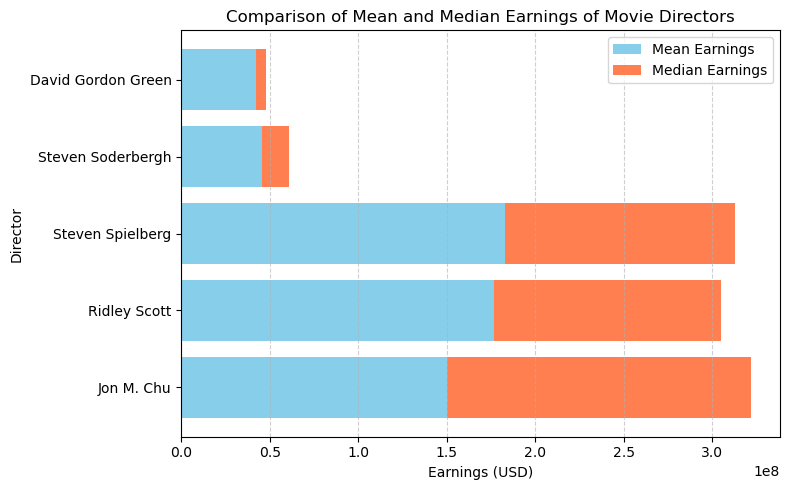

In [121]:
#generate data
top5_dir = roi_dir.sort_values(by=('ROI','count'),ascending=False).head(5)
# Create a horizontal bar graph
plt.figure(figsize=(8, 5))
bars1 = plt.barh(top5_dir['ROI'].index, top5_dir['ROI']['mean'], color='skyblue', label='Mean Earnings')
bars2 = plt.barh(top5_dir['ROI'].index, top5_dir['ROI']['median'], left=top5_dir['ROI']['mean'],color='coral', label='Median Earnings')

# Set labels and title
plt.xlabel('Earnings (USD)')
plt.ylabel('Director')
plt.title('Comparison of Mean and Median Earnings of Movie Directors')

# Add a legend
plt.legend()

# Display the plot
plt.gca().invert_yaxis()  # Invert the y-axis to display the director with the highest earnings at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

---
### Conclusions
---
This analysis has yielded the following conclusions in order to generate a high ROI:

- **A film of the genre combination Action,Adventure,Sci-Fi should be among the first to be created.** This genre combinationhas proved to frequently yeild a high ROI along with the genre combinations of **Adventure,Drama,Sci-Fi** and **Comedy,Mystery** as they also have a high profitability in the box office. 
- **The films should be released in the months of May, June or July.** It should also be noted that films typically do well in November as well. The top three months have shown the highest profitability in this regard. 
- **The directors to be contacted to direct the new films should be *Steven Spielberg*, *Ridley Scott* and *Jon M. Chu*.** Their names are well known in the industry and they audience loves them as their films have a general positive rating. Their skill in scrpting and working the cast is seen in the return they hae generated through a high ROI. 

---
### Further Considerations
---

The next steps to be carried out after this analysis are:
- **Conducting further analysis on specific genres.** The data shows results based on a combination of genres and a further analysis to determine the profitability of these genres and hence influence the film making process. Some things to look out for would be the target audience for these genres and probably their purchasing power. I would also consider what specific elements of this genres enable them to perform better in terms of ROI.
- **Investigating the periods in which movies were released.** The data suggests that most movies are most profitable between the middle of the year but other factors such as relatablilty of the film, current events and trends and audience type could be factors to consider that would influence the ROI.
- **Checking how movie ratings(G to R-rated films) affect the ROI.** This could possibly influence the decision on the type of films to be created based on the target audience. 